<a href="https://colab.research.google.com/github/ghadfield32/Zero_to_Mastery_Learn_PyTorch_for_Deep_Learning/blob/main/05_modular_Pytorch_Object_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

turn our notebook code from a series of cells into the following Python files:

    data_setup.py - a file to prepare and download data if needed.
    engine.py - a file containing various training functions.
    model_builder.py or model.py - a file to create a PyTorch model.
    train.py - a file to leverage all other files and train a target PyTorch model.
    utils.py - a file dedicated to helpful utility functions.


Goal: python train.py --model MODEL_NAME --batch_size BATCH_SIZE --lr LEARNING_RATE --num_epochs NUM_EPOCHS

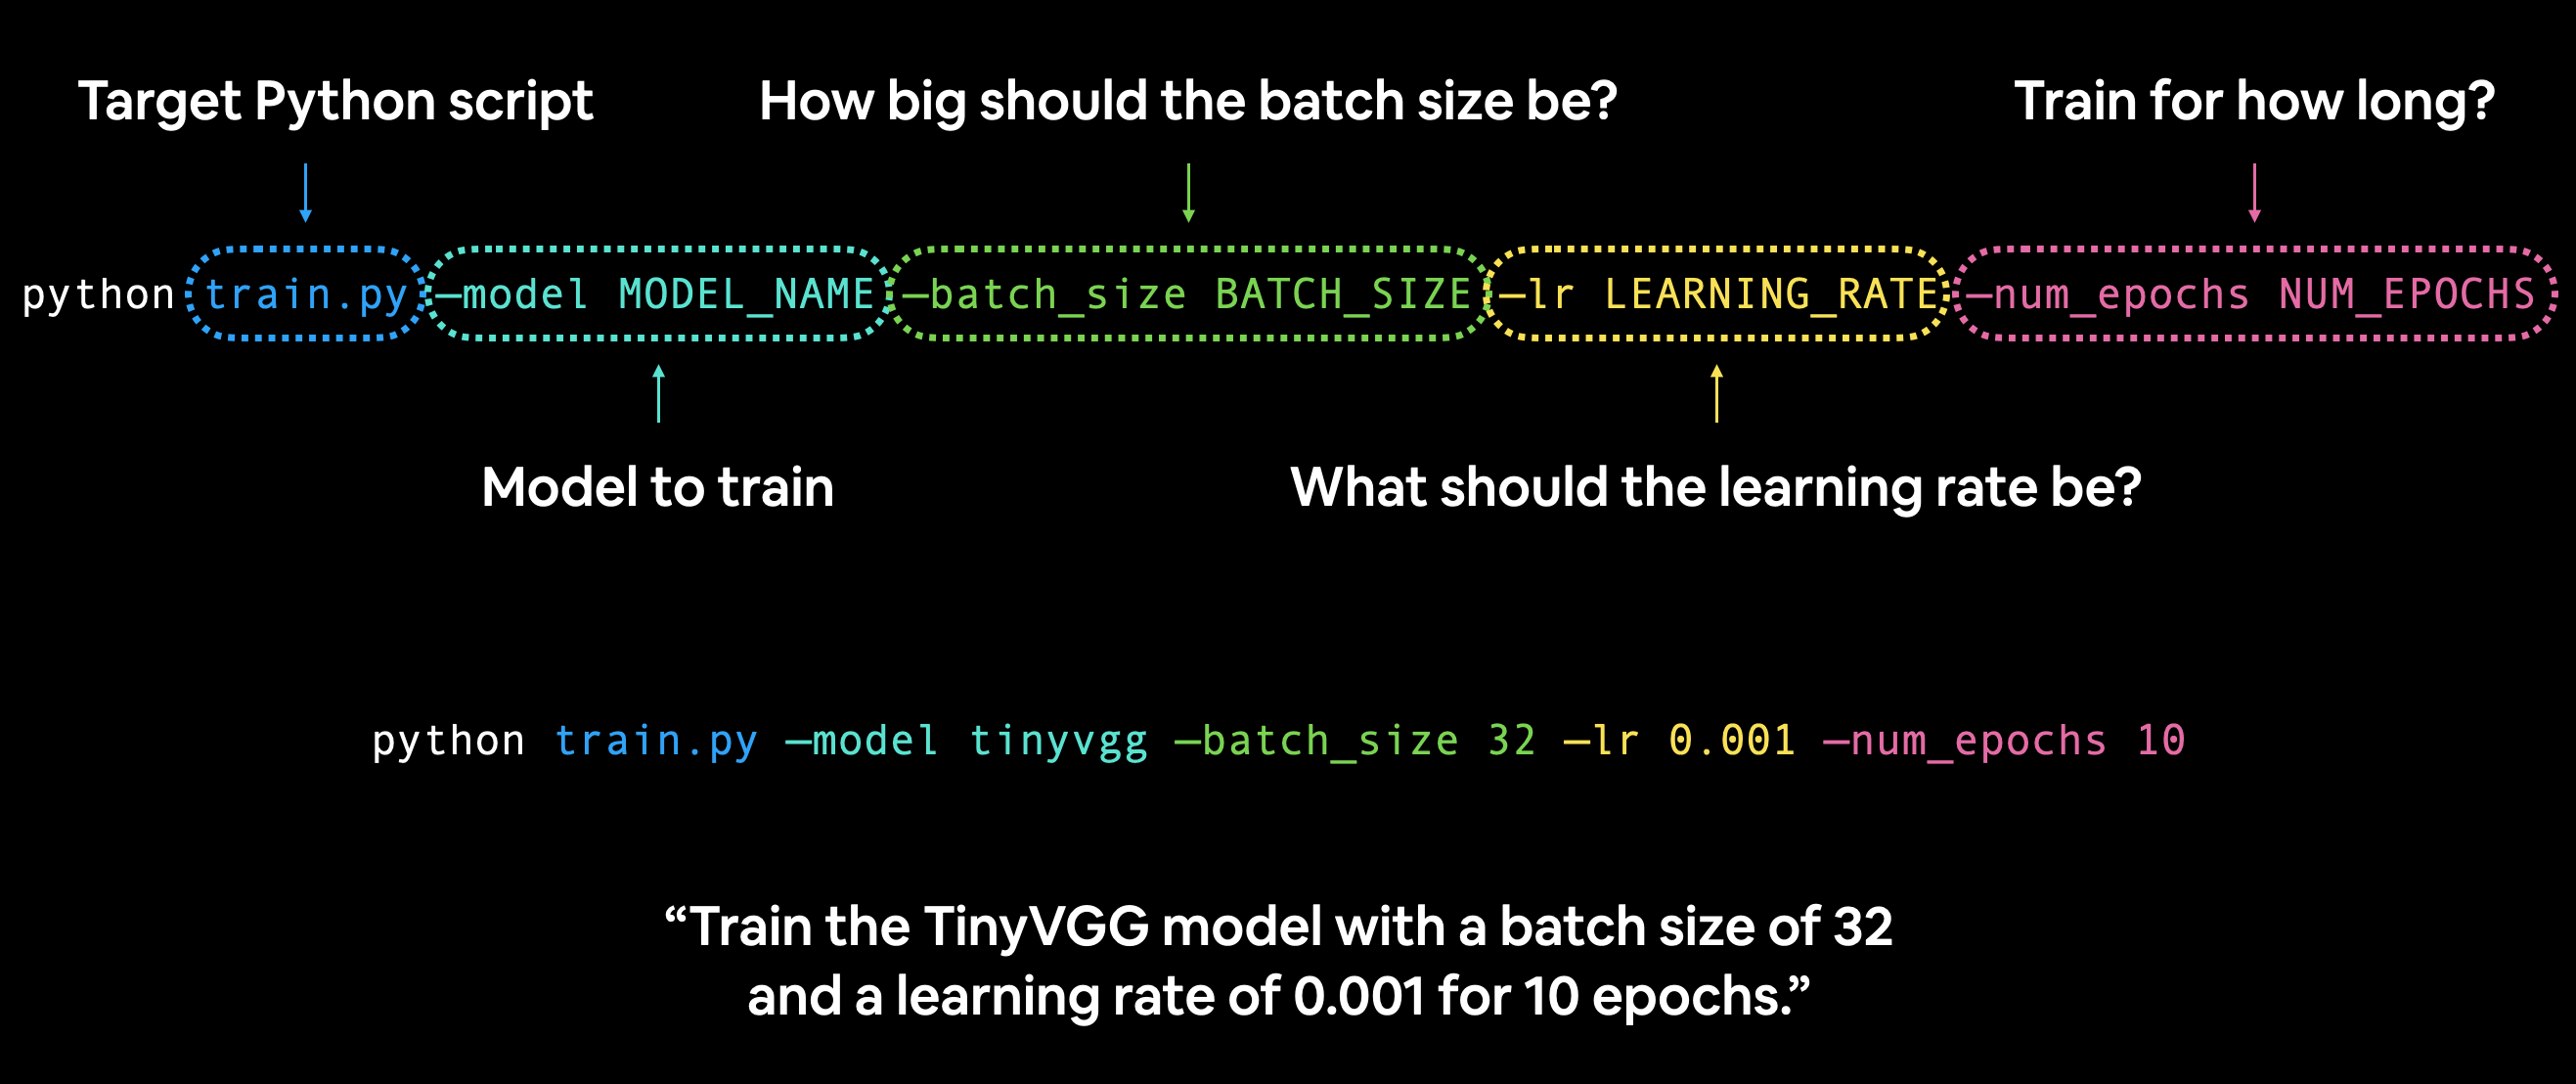

In [1]:
# Import modules required for train.py
import os
import torch
#import data_setup, engine, model_builder, utils #imports from your respository for train.py

from torchvision import transforms

In [2]:
import os
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

# Remove zip file
os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [3]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [4]:
from torchvision import datasets, transforms

# Create simple transform
data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Use ImageFolder to create dataset(s)
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


In [5]:
# Get class names as a list
class_names = train_data.class_to_idx #could also use .classes for name list
class_names

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [6]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader

batch_size = 32
num_workers = 1

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=batch_size, # how many samples per batch?
                              num_workers=num_workers, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7abd00283910>,
 <torch.utils.data.dataloader.DataLoader at 0x7abd00283e80>)

In [7]:
# Check out single image size/shape
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


2. Create Datasets and DataLoaders (data_setup.py)

In [8]:
!mkdir going_modular
import sys
sys.path.append('/content')


In [9]:
%%writefile going_modular/data_setup.py
"""
Contains functionality for creating PyTorch DataLoaders for
image classification data.
"""
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False, # don't need to shuffle test data
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

Writing going_modular/data_setup.py


Example usage: # Import data_setup.py
from going_modular import data_setup

Create train/test dataloader and get class names as a list
* train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(...)

***modular cell

In [10]:
%%writefile going_modular/model_builder.py
import torch
from torch import nn
from torchvision import models

class TinyVGG(nn.Module):
    """Creates the TinyVGG architecture.

    Replicates the TinyVGG architecture from the CNN explainer website in PyTorch.
    See the original architecture here: https://poloclub.github.io/cnn-explainer/

    Args:
    input_shape: An integer indicating number of input channels.
    hidden_units: An integer indicating number of hidden units between layers.
    output_shape: An integer indicating number of output units.
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
          nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                        stride=2)
        )
        self.conv_block_2 = nn.Sequential(
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
          nn.ReLU(),
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
          nn.ReLU(),
          nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
          nn.Flatten(),
          # Where did this in_features shape come from?
          # It's because each layer of our network compresses and changes the shape of our inputs data.
          nn.Linear(in_features=hidden_units*13*13,
                    out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x
        # return self.classifier(self.block_2(self.block_1(x))) # <- leverage the benefits of operator fusion



Writing going_modular/model_builder.py


***EX use

In [11]:
import torch

from going_modular import model_builder

device = "cuda" if torch.cuda.is_available() else "cpu"

# Instantiate an instance of the model from the "model_builder.py" script
torch.manual_seed(42)
model_1 = model_builder.TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                                hidden_units=10,
                                output_shape=len(class_names)).to(device)
model_1


TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [12]:


# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_1.eval()
with torch.inference_mode():
    pred = model_1(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")



Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[ 0.0208, -0.0020,  0.0095]])

Output prediction probabilities:
tensor([[0.3371, 0.3295, 0.3333]])

Output prediction label:
tensor([0])

Actual label:
0


In [13]:
!pip install typing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26304 sha256=a34cdaf5e60d18299d15a366bb042b641b862cf5f9ba90f2df0186c6ddd5d421
  Stored in directory: /root/.cache/pip/wheels/7c/d0/9e/1f26ebb66d9e1732e4098bc5a6c2d91f6c9a529838f0284890
Successfully built typing


In [14]:
%%writefile going_modular/engine.py
"""
Contains functions for trainig and testing a Pytorch model

"""
from typing import Dict, List, Tuple
import torch
import torch.nn
import torch.utils.data
import torch.optim
from tqdm.auto import tqdm

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,  # Corrected DataLoader
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)

    """
    #Put model in train mode
    model.train()

    #Setup train loss and train accuracy
    train_loss, train_acc = 0, 0

    #loop through dataloader in batches:
    for batch, (X, y) in enumerate(dataloader):
      #send data to devices
      X, y = X.to(device), y.to(device)

      #forward pass
      y_pred = model(X)

      #calculate and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      #optimizer zero grad
      optimizer.zero_grad()

      #Loss backward prop
      loss.backward()

      #Optimizer step
      optimizer.step()

      #calculate metrics across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    #adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss/len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List[float]]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results





Writing going_modular/engine.py


In [15]:
%%writefile going_modular/utils.py
"""
Contains various utility functions for PyTorch model training and saving.
"""
from pathlib import Path

import torch

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
    """Saves a PyTorch model to a target directory.

    Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

    Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
    """
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
             f=model_save_path)

Writing going_modular/utils.py


In [16]:
%%writefile going_modular/train.py

"""
Trains a PyTorch image classification model using device-agnostic code.
"""

import os
import argparse
import torch
from torchvision import transforms
import data_setup, engine, model_builder, utils
import json
from model_builder import *  # Import all models
import inspect
import torch

def get_model_list():
    model_list = []
    for name, obj in inspect.getmembers(model_builder):
        if inspect.isclass(obj) and issubclass(obj, torch.nn.Module):
            model_list.append(name)
    return model_list

model_choices = get_model_list()

train_dir_default = "data/pizza_steak_sushi/train"
train_dir_default = "data/pizza_steak_sushi/train"
epochs_default = 5
batch_size_default = 32
hidden_units_default = 10
lr_default = 0.001
model_type_default = "TinyVGG"
model_choices_default = model_choices

# Set up the argument parser
parser = argparse.ArgumentParser(description="Train a PyTorch image classification model.")
parser.add_argument("--train_dir", type=str, default=train_dir_default, help="Directory for training data")
parser.add_argument("--test_dir", type=str, default=train_dir_default, help="Directory for testing data")
parser.add_argument("--epochs", type=int, default=epochs_default, help="Number of training epochs")
parser.add_argument("--batch_size", type=int, default=batch_size_default, help="Batch size for training/testing")
parser.add_argument("--hidden_units", type=int, default=hidden_units_default, help="Number of hidden units in the model")
parser.add_argument("--learning_rate", type=float, default=lr_default, help="Learning rate for the optimizer")
parser.add_argument("--model_type", type=str, default=model_type_default, choices=model_choices, help="Type of model to train")

# Parse arguments
args = parser.parse_args()

# Use arguments
NUM_EPOCHS = args.epochs
BATCH_SIZE = args.batch_size
HIDDEN_UNITS = args.hidden_units
LEARNING_RATE = args.learning_rate
train_dir = args.train_dir
test_dir = args.test_dir
MODEL_TYPE = args.model_type

# Setup target device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create transforms
data_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

# Create DataLoaders with help from data_setup.py
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=data_transform,
    batch_size=BATCH_SIZE
)

os.makedirs("models", exist_ok=True)
# Save class names
class_names_path = "models/class_names.json"  # Adjust the path as needed
with open(class_names_path, "w") as f:
    json.dump(class_names, f)

# Create model based on the selected type
if MODEL_TYPE == "TinyVGG":
    model = model_builder.TinyVGG(
        input_shape=3,
        hidden_units=HIDDEN_UNITS,
        output_shape=len(class_names)
    ).to(device)
elif MODEL_TYPE == "ModelX":
    # Example for another model, replace with actual model code
    model = model_builder.ModelX(
        some_parameter=123,  # Replace with actual parameters
        another_parameter=456
    ).to(device)
else:
    raise ValueError(f"Unknown model type: {MODEL_TYPE}")

# Set loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

# Start training with help from engine.py
engine.train(model=model,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             epochs=NUM_EPOCHS,
             device=device)

os.makedirs("models", exist_ok=True)
# Save the model state dictionary
model_state_dict_path = "models/05_going_modular_script_mode_tinyvgg_model_state_dict.pth"
torch.save(model.state_dict(), model_state_dict_path)

# Save the model with help from utils.py
utils.save_model(model=model,
                 target_dir="models",
                 model_name="05_going_modular_script_mode_tinyvgg_model.pth")

os.makedirs("hyperparameters", exist_ok=True)
# Save hyperparameters
hyperparams = {
    "model_type": MODEL_TYPE,
    "hidden_units": HIDDEN_UNITS,
    # Add other relevant hyperparameters here
}
with open("hyperparameters/hyperparams.json", "w") as f:
    json.dump(hyperparams, f)



Writing going_modular/train.py


In [17]:
import os

os.makedirs("going_modular", exist_ok=True)
os.makedirs("hyperparameters", exist_ok=True)

!python going_modular/train.py --model_type TinyVGG --learning_rate 0.001 --epochs 20 --batch_size 64 --hidden_units 20 #--train_dir "path/to/train_data" --test_dir "path/to/test_data"

#Parameter defaults and options to change:
#train_dir_default = "data/pizza_steak_sushi/train"
#train_dir_default = "data/pizza_steak_sushi/train"
#epochs_default = 5
#batch_size_default = 32
#hidden_units_default = 10
#lr_default = 0.001
#model_type_default = "TinyVGG"

  0% 0/20 [00:00<?, ?it/s]Epoch: 1 | train_loss: 1.1017 | train_acc: 0.3106 | test_loss: 1.0950 | test_acc: 0.4258
  5% 1/20 [00:07<02:23,  7.54s/it]Epoch: 2 | train_loss: 1.0856 | train_acc: 0.4264 | test_loss: 1.0806 | test_acc: 0.3594
 10% 2/20 [00:13<02:01,  6.75s/it]Epoch: 3 | train_loss: 1.0575 | train_acc: 0.4339 | test_loss: 1.0334 | test_acc: 0.4366
 15% 3/20 [00:21<02:02,  7.22s/it]Epoch: 4 | train_loss: 1.0139 | train_acc: 0.4923 | test_loss: 0.9592 | test_acc: 0.5397
 20% 4/20 [00:25<01:38,  6.13s/it]Epoch: 5 | train_loss: 0.9601 | train_acc: 0.5465 | test_loss: 0.9068 | test_acc: 0.5704
 25% 5/20 [00:29<01:16,  5.08s/it]Epoch: 6 | train_loss: 0.9077 | train_acc: 0.5743 | test_loss: 0.8756 | test_acc: 0.5711
 30% 6/20 [00:33<01:08,  4.86s/it]Epoch: 7 | train_loss: 0.8740 | train_acc: 0.5665 | test_loss: 0.8382 | test_acc: 0.6283
 35% 7/20 [00:36<00:56,  4.33s/it]Epoch: 8 | train_loss: 0.8460 | train_acc: 0.6044 | test_loss: 0.8224 | test_acc: 0.6361
 40% 8/20 [00:39<00:47, 

In [18]:
%%writefile going_modular/predict.py
"""
Predict on custom images
"""
import sys
sys.path.append('/content/going_modular')

import os
import argparse
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import data_setup, engine, model_builder, utils
from model_builder import * # Adjust the import statement as necessary
import inspect
import json

#Model list
def get_model_list():
    model_list = []
    for name, obj in inspect.getmembers(model_builder):
        if inspect.isclass(obj) and issubclass(obj, torch.nn.Module):
            model_list.append(name)
    return model_list

model_choices = get_model_list()

# Load class names
class_names_path = "models/class_names.json"  # Adjust the path as needed
with open(class_names_path, "r") as f:
    class_names = json.load(f)

model_type_default = 'TinyVGG'  # Replace with your default model type
class_names_default = class_names
hidden_units_default = 10
device_default = "cuda" if torch.cuda.is_available() else "cpu"

hyperparams_path = "/content/hyperparameters/hyperparams.json"
if os.path.exists(hyperparams_path):
    with open(hyperparams_path, "r") as f:
        hyperparams = json.load(f)
    model_type_hyperparam = hyperparams.get("model_type", model_type_default)
    hidden_units_hyperparam = hyperparams.get("hidden_units", hidden_units_default)
else:
    model_type_hyperparam = model_type_default
    hidden_units_hyperparam = hidden_units_default


# Set up argument parsing
parser = argparse.ArgumentParser(description="Predict on custom images using a trained model.")
parser.add_argument("--model_path", type=str, required=True, help="Path to the trained model.")
parser.add_argument("--image_path", type=str, required=True, help="Path to the image for prediction.")
parser.add_argument("--class_names", nargs='+', default=class_names_default, help="List of class names.")
parser.add_argument("--device", type=str, default=device_default, help="Compute device to use.")
parser.add_argument("--hidden_units", type=int, default=hidden_units_hyperparam, help="Number of hidden units in the model")
parser.add_argument("--model_type", type=str, default=model_type_hyperparam, choices=model_choices, help="Type of model to train")

args = parser.parse_args()
device = torch.device(args.device)

def load_model(model_type, hidden_units, model_path, device):
    # Load model based on type and parameters
    # For example:
    if model_type == "TinyVGG":
        model = TinyVGG(input_shape=3, hidden_units=hidden_units, output_shape=len(class_names))
    elif model_type == "ModelX":
        model = ModelX(some_parameter=123)  # Adjust accordingly
    else:
        raise ValueError(f"Unknown model type: {model_type}")

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    return model

model = load_model(args.model_type, args.hidden_units, args.model_path, device)

transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Adjust based on the input size used during training
    transforms.ToTensor()
])

def load_and_transform_image(image_path, transform):
    image = Image.open(image_path)
    image = transform(image)
    return image

image_tensor = load_and_transform_image(args.image_path, transform)

def pred_and_plot_image(model: torch.nn.Module,
                        image_tensor: torch.Tensor,
                        device: torch.device,
                        class_names: list = class_names):
    """
    Makes a prediction on a target image and plots the image with its prediction.
    Args:
    model: The trained PyTorch model.
    image_tensor: The image tensor to make a prediction on.
    class_names: Optional list of class names for the model's output.
    device: The device to perform computation (e.g., 'cuda' or 'cpu').

    Ex usage:
    # Pred on our custom image
    pred_and_plot_image(model=model_1,
                    image_tensor=image_tensor,
                    class_names=class_names,
                    device=device)
    """
    # 1. Make sure the model is on the target device
    model.to(device)

    # 2. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image tensor
        target_image_tensor = image_tensor.unsqueeze(dim=0).to(device)

        # Make a prediction on the image tensor
        target_image_pred = model(target_image_tensor)

    # 3. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 4. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 5. Plot the image alongside the prediction and prediction probability
    plt.imshow(image_tensor.permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);
    # Save the plot to a file
    plt.savefig("prediction_output.png")

    # Show the plot (this might not work in all environments)
    plt.show()

# Load and transform image
image = load_and_transform_image(args.image_path, transform)

# At the bottom of your script, where the function call is made
pred_and_plot_image(model, image_tensor, device, args.class_names or class_names_default)



Writing going_modular/predict.py


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])
Transformed image saved at /content/data/pizza_steak_sushi/transformed_image.jpeg


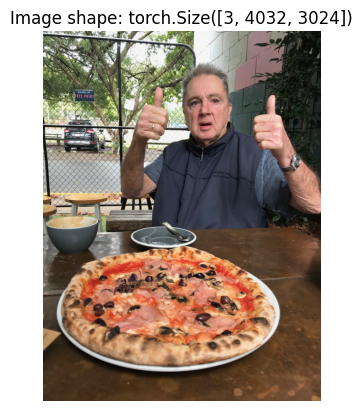

In [19]:
# Importing the requests package for downloading files
import requests

# Importing PyTorch and torchvision for image processing and transformations
import torch
from torchvision import transforms, utils
import torchvision.io

# Importing matplotlib for image visualization
import matplotlib.pyplot as plt

# Importing pathlib for file path handling
from pathlib import Path

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
#print(f"Custom image tensor:\n{custom_image_uint8}\n")
#print(f"Custom image shape: {custom_image_uint8.shape}\n")
#print(f"Custom image dtype: {custom_image_uint8.dtype}")

# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255.

# Print out image data
#print(f"Custom image tensor:\n{custom_image}\n")
#print(f"Custom image shape: {custom_image.shape}\n")
#print(f"Custom image dtype: {custom_image.dtype}")

# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

#custom_image_transformed location
custom_image_transformed_location = "/content/data/pizza_steak_sushi"

# Set the path where you want to save the transformed image
transformed_image_path = custom_image_transformed_location + "/transformed_image.jpeg"

# Save the transformed image
torchvision.utils.save_image(custom_image_transformed, transformed_image_path)

print(f"Transformed image saved at {transformed_image_path}")


#save image


In [20]:
!python going_modular/predict.py --model_type TinyVGG --hidden_units 20 --model_path /content/models/05_going_modular_script_mode_tinyvgg_model.pth --image_path /content/data/04-pizza-dad.jpeg


Figure(640x480)


In [21]:
import inspect
from going_modular import model_builder
import torch

def get_model_list():
    model_list = []
    for name, obj in inspect.getmembers(model_builder):
        if inspect.isclass(obj) and issubclass(obj, torch.nn.Module):
            model_list.append(name)
    return model_list

model_choices = get_model_list()

print(get_model_list())

['TinyVGG']
